## Load data

In [1]:
import pandas as pd
import numpy as np
import itertools as it
import datetime as dt
import sys
import json
import os
import re

sys.path.append('./../modules')

from explorer import *
from utils import *
from visual import *

In [2]:
# PROJECT_DIR = os.getcwd()
# IMAGES_PATH = os.path.join(PROJECT_DIR, "images")
# os.makedirs(IMAGES_PATH, exist_ok=True)

In [3]:
DATA_PATH = './../databases/json-data/'

# Inspect the number of user json files
print(f"number of files: {len(list(retrieve_files(DATA_PATH)))}")

# Load data
backup = combine_data(DATA_PATH)

number of files: 6106


In [4]:
# Save data to the dedicated folder
backup.to_csv('./../databases/csv-data/backup.csv', index=False)

In [5]:
data = backup.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20986 entries, 0 to 20985
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uid             20986 non-null  object
 1   date            20986 non-null  object
 2   hasGoal         20986 non-null  bool  
 3   hasRevenue      20986 non-null  bool  
 4   duration        20986 non-null  object
 5   deviceCategory  20986 non-null  object
 6   channel         20986 non-null  object
 7   event           19657 non-null  object
 8   pageview        20986 non-null  object
 9   page            20986 non-null  object
 10  action          20986 non-null  object
dtypes: bool(2), object(9)
memory usage: 1.5+ MB


In [6]:
for name in ['hasGoal', 'hasRevenue', 'deviceCategory', 'channel']:
    print(f"{name} categories: \n{data[name].value_counts()}\n")

hasGoal categories: 
False    20986
Name: hasGoal, dtype: int64

hasRevenue categories: 
False    20986
Name: hasRevenue, dtype: int64

deviceCategory categories: 
desktop    10433
mobile     10252
tablet       301
Name: deviceCategory, dtype: int64

channel categories: 
Organic Search    8942
Direct            6786
Paid Search       2683
Referral          2087
Social             414
Email               42
(Other)             32
Name: channel, dtype: int64



Figure saved, piechart-channel


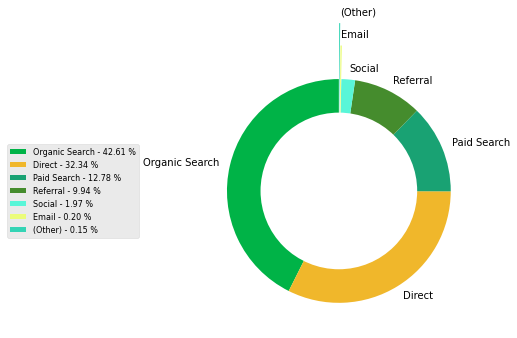

In [7]:
var = 'channel'
plot_piechart(var, data, explode=(0,0,0,0,0,0.3,0.5))
save_fig(f'piechart-{var}')

In [8]:
pageview = [x for x in data['pageview'].map(int).values if x<=50]
data['event'].replace({np.nan: '0'}, inplace=True)
event = [x for x in data['event'].map(int).values if x<=30]

C:\Users\Lostcz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Figure saved, displot-pageview_per_session


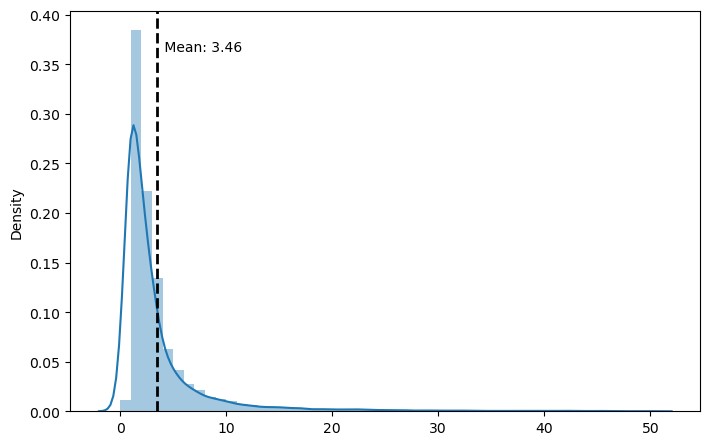

In [9]:
var = pageview; label = "pageview_per_session" 
plot_distribution(var)
save_fig(f'displot-{label}')

C:\Users\Lostcz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Figure saved, distribution-event_per_session


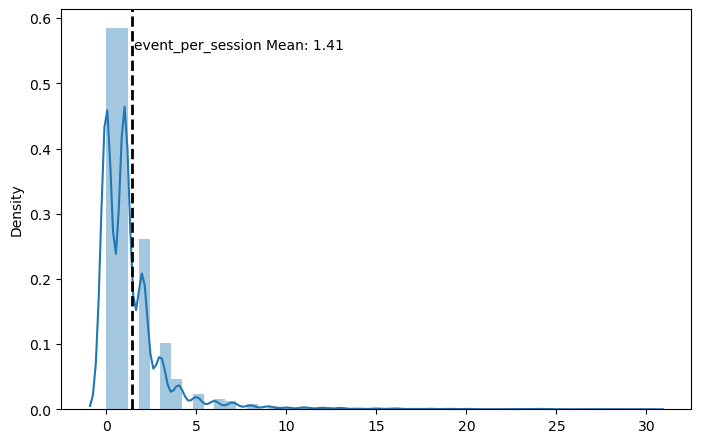

In [10]:
var = event; label = "event_per_session"
plot_distribution(var, label=label)
save_fig(f'distribution-{label}')

In [11]:
def convert_to_secs(duration):
    m, s = map(int, duration.split(':'))
    return m*60+s+1

def count_cat(col_list):
    """count the categories of a feature
    return a list of categories of the feature"""
    cat_set = set()
    for item in col_list:
        cat_set.add(item)
    return cat_set

def clean_multi_cat_col(df, col_name, index_col='uid'):
    """clean columns with multiple options
    transform each option into a dummny variable"""
    new_df = df.groupby(index_col, as_index=True)[col_name].apply(count_cat).to_frame().rename(columns={0: col_name})
    new_df[col_name] = new_df[col_name].apply(frozenset)
    for cat in frozenset.union(*new_df[col_name]):
        new_df[cat] = new_df.apply(lambda _: int(cat in _[col_name]), axis=1)
    new_df.drop(columns=col_name, inplace=True)
    new_df = new_df.reset_index()
    return new_df

In [12]:
# Convert duration in minutes to seconds
data['duration'] = data['duration'].map(convert_to_secs)
# Parse date
data['date'] = pd.to_datetime(data['date'])

#### Clean Category Columns

In [13]:
# Calculate user active days
active_days = \
data.groupby('uid')['date'].apply(cal_active_days).to_frame().rename(columns={'date': 'active_days'}).reset_index()

# Calcualte average time users being active on the website
avg_duration = \
data.groupby('uid')['duration'].apply(np.mean).round(2).to_frame().rename(columns={'duration': 
                                                                                   'avg_duration'}).reset_index()
# Calcualte user's sessions
sessions = \
data.groupby('uid')['duration'].size().to_frame().rename(columns={'duration': 'sessions'}).reset_index()

# Clean 'channel' and 'device' columns
# Map features into dummy colummns
channel = clean_multi_cat_col(data, 'channel')
device = clean_multi_cat_col(data, 'deviceCategory')

# Clean 'pageview' column and count the number of pages users viewed
data['pageview'] = data['pageview'].replace(np.nan, 0)
data['pageview'] = data['pageview'].map(lambda x: int(x))

# Calculate the average number of pageviews
avg_pageview = \
data.groupby('uid', as_index=True)['pageview'].apply(np.mean).round(2).to_frame().rename(columns={'pageview': 
                                                                                        'avg_pageview'}).reset_index()

total_pageview = \
data.groupby('uid', as_index=True)['pageview'].apply(np.sum).round(2).to_frame().rename(columns={'pageview': 
                                                                                        'total_pageview'}).reset_index()
# Clean 'event' column and count the number of events users engaged in
data['event'] = data['event'].replace(np.nan, 0)
data['event'] = data['event'].map(lambda x: int(x))

# Calculate the average number of events
avg_event = \
data.groupby('uid')['event'].apply(np.mean).round(2).to_frame().rename(columns={'event': 'avg_event'}).reset_index()
total_event = \
data.groupby('uid')['event'].apply(np.sum).round(2).to_frame().rename(columns={'event': 'total_event'}).reset_index()

#### Clean Text Columns

In [14]:
grouped = data.groupby('uid', as_index=False)['action'].first()
grouped['forum'] = grouped['action'].map(lambda x: 1 if x.find('Forum')!=-1 else 0)
grouped['triage'] = grouped['action'].map(lambda x: 1 if x.find('Triage')!=-1 else 0)
grouped['community'] = grouped['action'].map(lambda x: 1 if x.find('Community Sign In')!=-1 else 0)
grouped.drop(columns='action', axis=1, inplace=True)

### Combine Features

In [15]:
# Merge individual feature dataframes on 'uid'
basic_info = active_days.merge(avg_duration, on='uid', how='left').\
                         merge(sessions, on='uid', how='left').\
                         merge(avg_pageview, on='uid', how='left').\
                         merge(total_pageview, on='uid', how='left').\
                         merge(avg_event, on='uid', how='left').\
                         merge(total_event, on='uid', how='left').\
                         merge(device, on='uid', how='left').\
                         merge(channel, on='uid', how='left').\
                         merge(grouped, on='uid', how='left')
basic_info

,uid,active_days,avg_duration,sessions,avg_pageview,total_pageview,avg_event,total_event,mobile,tablet,...,Email,(Other),Paid Search,Organic Search,Referral,Social,Direct,forum,triage,community
0,000708d176f8010cb95adfa271ad797d,1,145.00,1,3.00,3,2.0,2,1,0,...,0,0,0,1,0,0,0,0,0,0
1,001291be71d38604bc02f7c469b80704,1,15.50,2,1.00,2,0.5,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,00310de616cf03e7740b739ead30aed2,121,102.75,4,1.75,7,1.0,4,1,0,...,0,0,0,0,1,0,1,1,0,0
3,00328efeb249f607b41564c486a73322,7,67.25,4,1.25,5,1.0,4,0,0,...,0,0,0,0,0,0,1,0,0,0
4,003eb8138953601befd26174f9eab5b5,13,1.00,3,1.00,3,0.0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,ffd1a1be6fe774217f46a073bdb70a4f,1,99.50,2,1.50,3,1.0,2,1,0,...,0,0,0,1,0,0,1,0,0,0
6102,ffd5f1f34196586d7d68cd18b0879143,1,320.50,2,3.00,6,0.0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
6103,ffe0c505101202f29745211fdb7a41c0,1,134.00,1,3.00,3,1.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6104,ffe0ebe625dc3376651625a1319a48f2,2,27.00,5,1.40,7,0.8,4,0,0,...,0,0,0,1,1,0,0,0,0,0


In [16]:
# Save preprocessed dataset
basic_info.to_csv('./../databases/csv-data/basic_info.csv', index=False)

In [17]:
sessions = basic_info['sessions'].values
active_days = basic_info['active_days'].values

C:\Users\Lostcz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Figure saved, displot-session_per_user


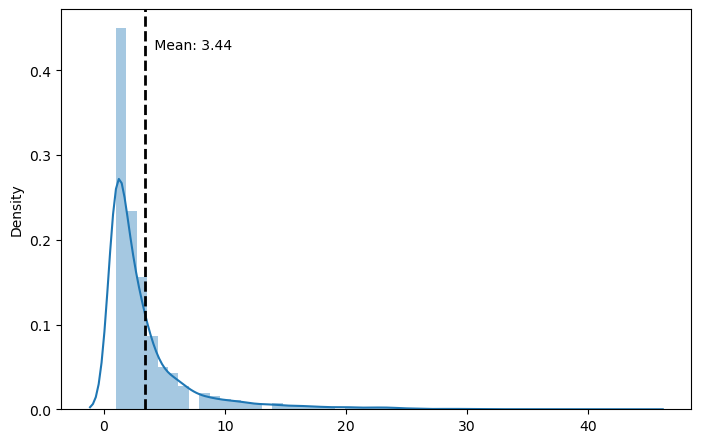

In [18]:
var = sessions; label = "session_per_user" 
plot_distribution(var)
save_fig(f'displot-{label}')

C:\Users\Lostcz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Figure saved, displot-active_days_per_user


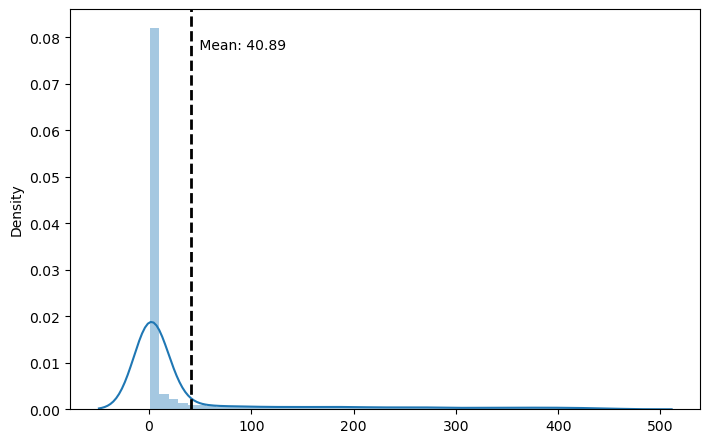

In [19]:
var = active_days; label = "active_days_per_user" 
plot_distribution(var)
save_fig(f'displot-{label}')

## Clean action column

In [20]:
def get_triage_df(data):
    event = data[['uid', 'action']]
    event = event.drop_duplicates().reset_index(drop=True)
    event['action'] = event['action'].map(find_triage_info)
    # Select entries with triage info
    triage_df = event[event['action'].map(lambda x: len(x)) > 0]
    triage_df = triage_df.reset_index(drop=True)
    return triage_df

If a user hit the right-corner "how can i help" tag, the following page will pop out. If the user continue to fill in the table, we will get "triage data" that contains the user's age, region and issue infomation when he uses the service.

<img src = 'https://drive.google.com/uc?id=1FMWEp7EzK_Qlst7eet-fHv9p0jtZRqyf' width="70%"  align="left">

This piece of information is stored in user's json file under the **"event"** feature. However, the number of users who provide such informaiton is very small. There is only 52 out of nearly 2000 avaialbe data. Given that the information is not complete, it would be more preferable to use it as a binary variable to indicate whether users are seeking additional help.

In [21]:
triage_df = get_triage_df(data)
print(f"{len(triage_df)} rows of data")
triage_df.head()

128 rows of data


,uid,action
0,0369f22b85f04451f411fadae37666ca,"[(age, 28), (mood, 5)]"
1,03aea09a6f8a9f1adf77f3c6d8250c6e,"[(age, 15), (mood, 1)]"
2,064fdd4f292b83dc06fac87492f24d31,"[(age, 22), (location, London - Newham), (sear..."
3,065ab04bd10f29c6e9788f3df935160e,"[(age, 17), (mood, 3)]"
4,07608d709b2ad37d2becf5c36ca672c1,"[(age, 29), (mood, 1)]"


## Clean page column

The "page" column contains various contents, including articles a user viewed, course info, discussion topics, etc.

In [22]:
data['page'][123]

"The winning Christmas campaign (spoiler: it's yours!) — The Mix Support Community|Recent Discussions — The Mix Support Community|The Mix Community|Shaunie — The Mix Support Community|September photo challenge - Page 3 — The Mix Support Community|The Mix — The Mix Support Community|General chit chat (OP GreenTea) - Page 486 — The Mix Support Community|Anything Goes — The Mix Support Community|Health & Wellbeing — The Mix Support Community|Highlights of the week! - Page 2 — The Mix Support Community|Positivity Corner — The Mix Support Community|What are you listening to right now? - Page 32 — The Mix Support Community|Travel & Free Time — The Mix Support Community|Creative — The Mix Support Community|General chit chat (OP GreenTea) - Page 485 — The Mix Support Community|Time for another ranty thread - Page 372 — The Mix Support Community|Recent Activity — The Mix Support Community"

In [78]:
page_df = clean_page_col(data)
page_df.shape

(32813, 2)

In [25]:
# If we directly clean page column we will have fewer user id records, 
# i.e., the number of example is fewer than the dataframe data
page_df = clean_page_col(data)
# Find user ids with NA pages and store it as page_sup
page_sup = data[data['uid'].isin(page_df[page_df['page'] == 'NaN']['uid'])]
page_df2 = clean_page(page_sup)
page_df = pd.concat([page_df, page_df2], axis=0)
page_df['page'].replace('NaN', np.nan, inplace=True)
page_df.dropna(subset=['page'], inplace=True)
page_df = page_df.reset_index()
page_df

,index,uid,page
0,0,000708d176f8010cb95adfa271ad797d,Being taken to small claims court
1,1,000708d176f8010cb95adfa271ad797d,Taking someone to small claims court
2,2,001291be71d38604bc02f7c469b80704,Why does she bleed when I finger her?
3,3,001291be71d38604bc02f7c469b80704,Fingering a girl
4,4,00310de616cf03e7740b739ead30aed2,Thank you
...,...,...,...
32937,152,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 8
32938,153,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 7
32939,154,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 6
32940,155,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 5


Figure saved, page_frequency


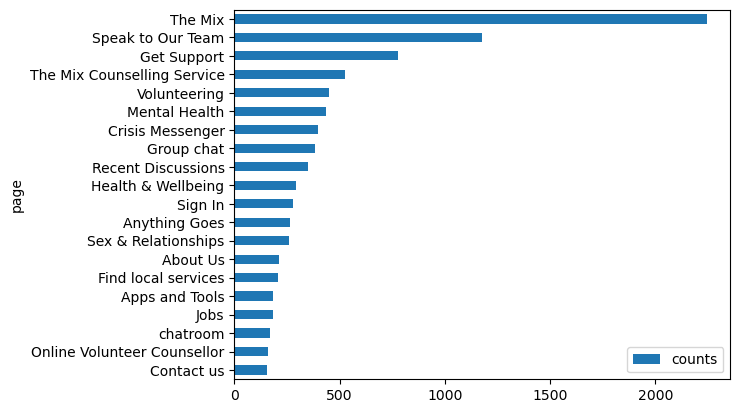

In [26]:
page_counts = page_df.groupby('page').size().sort_values(ascending=True)
page_counts_df = page_counts.to_frame(name='counts').reset_index()

plt.style.use("default")
page_counts_df[-20:].plot.barh(x='page')
save_fig('page_frequency')

In [27]:
page_df

,index,uid,page
0,0,000708d176f8010cb95adfa271ad797d,Being taken to small claims court
1,1,000708d176f8010cb95adfa271ad797d,Taking someone to small claims court
2,2,001291be71d38604bc02f7c469b80704,Why does she bleed when I finger her?
3,3,001291be71d38604bc02f7c469b80704,Fingering a girl
4,4,00310de616cf03e7740b739ead30aed2,Thank you
...,...,...,...
32937,152,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 8
32938,153,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 7
32939,154,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 6
32940,155,f7a8dd27d3c07718c967ba26ce4d199e,Digital Connector Training: Module 5


In [28]:
def find_page_pairs(x):
    pairs = pd.DataFrame(list(it.permutations(x.values, 2)), columns=['page', 'related page'])
    return pairs

In [29]:
page_combinations = page_df.groupby('uid')['page'].apply(find_page_pairs)

combination_counts = page_combinations.groupby(['page', 'related page']).size()
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values('size', ascending=False, inplace=True)

In [30]:
def plot_related_pages(page_title, n=20):
    target_df = combination_counts_df[combination_counts_df['page']==page_title]
    target_df[:n]
    # Visualization setting
    pal = sns.color_palette("Greens_d", n)
    rank = target_df[:n]['size'].argsort().argsort().values
    g = sns.barplot(y='related page', x='size', data=target_df[:n], palette=np.array(pal)[rank])
    plt.title(f"Related Pages for '{page_title}' ")
    plt.ylabel('')
    plt.xlabel('')

Figure saved, related_pages-The Mix


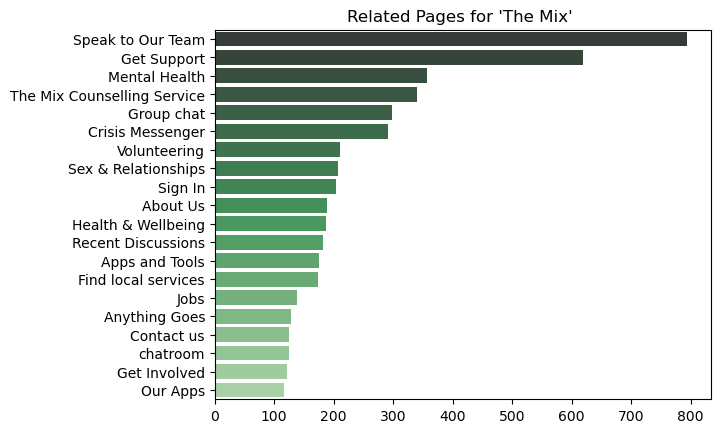

In [31]:
var = 'The Mix'
plot_related_pages(page_title=var)
save_fig(f'related_pages-{var}')

Figure saved, related_pages-Anything Goes


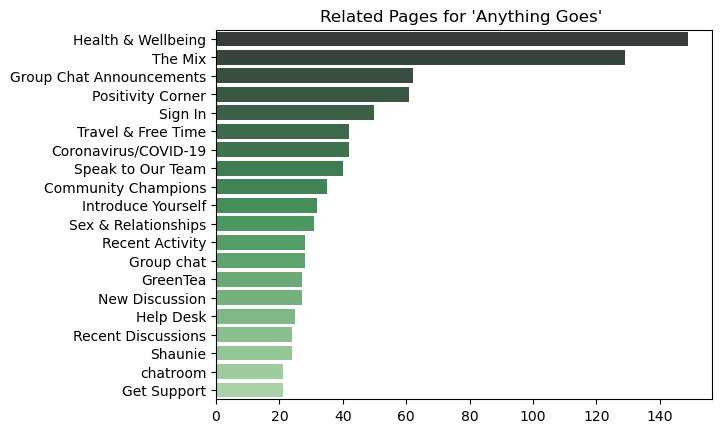

In [32]:
var = 'Anything Goes'
plot_related_pages(page_title=var)
save_fig(f'related_pages-{var}')

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [35]:
# Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
# Creating a list of custom stopwords
cust_words = ['page', 'mix', 'searched', 'find', 'general', 'read', 'first', 'please', 
              'op', 'greentea', 'speak', 'thread', 'post', 'posting', 
              'another', 'ambassador', 'voice', 'tw', 'th',]
stop_words = stop_words.union(cust_words)

In [36]:
re.sub('[^a-zA-Z]', ' ', 'Digital Connector Training: Module 6')

'Digital Connector Training  Module  '

In [37]:
import nltk

def build_corpus(df, text_col, stop_words):

    corpus = []
    for i in range(len(df)):
        # Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', df[text_col][i])
        # Convert to lowercase
        text = text.lower()
        # Remove whitespaces of the begining and the end
        text = text.strip()
        # Convert to list from string
        text = text.split()
        # Stemming
        ps = PorterStemmer()
        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words]
        text = " ".join(text)
        corpus.append(text)
    return corpus

In [38]:
corpus = build_corpus(page_df, 'page', stop_words)

Figure saved, wordcloud


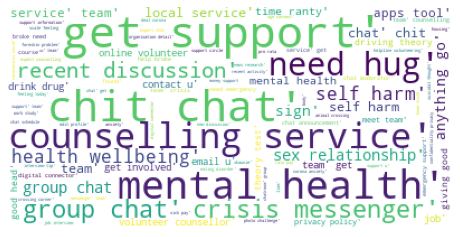

In [39]:
# Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(background_color='white', stopwords=stop_words,
                      max_words=100, max_font_size=40, 
                      random_state=42).generate(str(corpus))
print(wordcloud)


plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis('off')
save_fig('wordcloud')
plt.show()

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Most frequently occuring words
def uni_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), max_features=100).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Most frequently occuring bi-grams
def bi_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), max_features=100).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Most frequently occuring Tri-grams
def tri_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3), max_features=100).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
#Barplot of most freq words
import seaborn as sns

def plot_top_n_word_freq(corpus, func, n=25):
    top_words = func(corpus, n=n)
    xlabel = func.__name__.split('_')[0].title() + '-gram'
    ylabel='Freqency'
    top_df = pd.DataFrame(top_words, columns=[xlabel, ylabel])
    # Use seaborn for data visualization
    plt.figure(figsize=(10, 8))
    pal = sns.color_palette("Greens_d", len(top_df))
    rank = top_df[ylabel].argsort().argsort()
    g = sns.barplot(x=xlabel, y=ylabel, data=top_df, palette=np.array(pal)[rank])
    g.set_xticklabels(g.get_xticklabels(), rotation=60)
    

Figure saved, bi_top_30_words


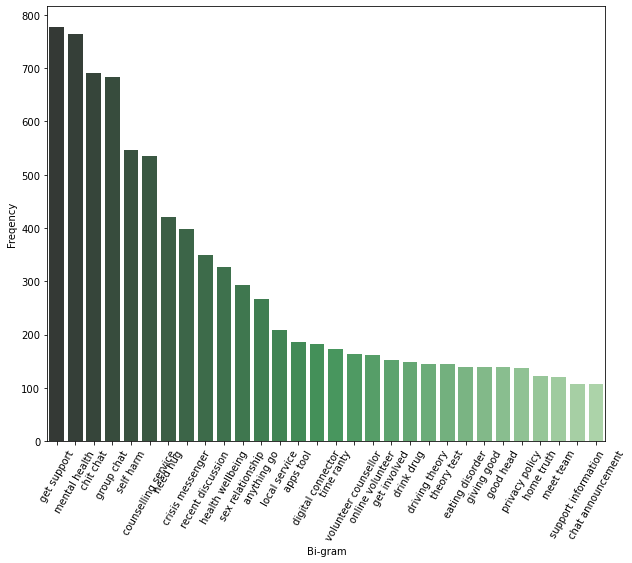

In [42]:
plot_top_n_word_freq(corpus, bi_top_n_words, n=30)
save_fig('bi_top_30_words')

## Page dataframe

In [43]:
with open('./../static/article.txt', 'r') as reader:
    article_dict = json.loads(reader.read())

In [44]:
def tidy_text(df, text_col, filter_num = 0):
    new_text = []
    for i in range(len(df)):
        text = re.sub('[^a-zA-Z]', ' ', df[text_col][i])
        # Convert to lowercase
        text = text.lower()
        # Remove whitespace at the beginning or end of the text
        text = text.strip()
        if len(re.findall(r'\w+', text)) >= filter_num:
            text = text
        else:
            text = np.nan
        new_text.append(text)
    return new_text


def sort_page_df(page_df):
    page_df['page'] = tidy_text(page_df, 'page')
    page_sorted = page_df.groupby('uid')['page'].apply(list)
    return page_sorted


def get_article_df(page_sorted, article_dict):
    user_df = pd.DataFrame(index = list(article_dict.keys()))
    
    for i in range(len(page_sorted)):
        user_id = page_sorted.index[i]
        user_content = set(page_sorted.iloc[i])

        user_list = []
        for j, page in enumerate(list(article_dict.keys())):
            search = user_content.intersection(set(article_dict[page]))
            user_cat = len(search)
            user_list.append(user_cat)
        user_df[user_id] = user_list
        user_article = user_df.T
#         user_article.columns = user_article.columns.map(lambda x: ("_").join(x.split()))
    return user_article

<img src = 'https://drive.google.com/uc?id=1HHYFM8md2YpNO7w-zlNXXcd6nXHdGfqt' width="90%"  align="left">

<img src = 'https://drive.google.com/uc?id=1iWWNgCtlAdlTqsTvaewPCQMdAqYq6a6C' width="70%"  align="left">

In [45]:
with open('./../static/article.txt', 'r') as reader:
    article_dict = json.loads(reader.read()) 

In [46]:
# Get category list
article_keys = list(article_dict.keys())
print(f"The number of subtopics: {len(article_keys)}")

The number of subtopics: 84


In [47]:
page_sorted = sort_page_df(page_df)
article_user = get_article_df(page_sorted, article_dict).T

In [48]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(article_user)


def content_similarity(content_name, df):
    index = list(df.index).index(content_name)
    distances, indices = model_knn.kneighbors(np.array(df.iloc[index, :]).reshape(1, -1), n_neighbors = 6)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(df.index[index].upper()))
        else:
            print('{0}: {1}, with distance of {2:.4f}:'.format(i, df.index[indices.flatten()[i]], 
                                                           distances.flatten()[i]))    

In [49]:
content_similarity('your career path', article_user)

Recommendations for YOUR CAREER PATH:

1: getting a job, with distance of 0.6921:
2: student life, with distance of 0.7038:
3: what qualification , with distance of 0.7718:
4: worker s rights and pay, with distance of 0.7749:
5: applying to university, with distance of 0.8264:


In [50]:
content_similarity('money management tips', article_user)

Recommendations for MONEY MANAGEMENT TIPS:

1: credit and debt, with distance of 0.4636:
2: buying a property, with distance of 0.5815:
3: money rights, with distance of 0.5912:
4: benefits, with distance of 0.6172:
5: student money, with distance of 0.6813:


In [51]:
def count_article_by_cat(user_article):
    article_cat = ['sex_relation', 'body', 'mental', 'drink_drug', 'housing',
                   'money', 'work_study', 'crime_safety', 'travel_lifestyle']
    # the first 16 columns containing sex_relation subtopics
    count_sex_relation = user_article.apply(
        lambda x: (x[:][:16]).sum(), axis=1)
    # column 16-23 containing body subtopics
    count_body = user_article.apply(lambda x: (x[:][16:24]).sum(), axis=1)
    # column 24-36 containing mental health subtopics
    count_mental = user_article.apply(lambda x: (x[:][24:37]).sum(), axis=1)
    # column 37-44 containing drink and drug subtopics
    count_drink_drug = user_article.apply(
        lambda x: (x[:][37:45]).sum(), axis=1)
    # column 45-50 containing housing subtopics
    count_housing = user_article.apply(lambda x: (x[:][45:51]).sum(), axis=1)
    # column 51-59 containing money subtopics
    count_money = user_article.apply(lambda x: (x[:][51:60]).sum(), axis=1)
    # column 60-72 containing work and study subtopics
    count_work = user_article.apply(lambda x: (x[:][60:73]).sum(), axis=1)
    # column 73-78 containing crime and safety subtopics
    count_crime = user_article.apply(lambda x: (x[:][73:78]).sum(), axis=1)
    # column 78-83 containing travel and lifestyle subtopics
    count_travel = user_article.apply(lambda x: (x[:][78:]).sum(), axis=1)

    count_df = pd.concat([count_sex_relation, count_body, count_mental, count_drink_drug,
                          count_housing, count_money, count_work, count_crime, count_travel], axis=1)
    count_df.columns = article_cat
    return count_df

## activities

<img src = 'https://drive.google.com/uc?id=1WIZTbKdPfJ3Nyfa4iJ8MBYD1l0yAlI7G' width="80%"  align="left">

In [52]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove whitespace
    text = text.strip()
    return text

def sort_topics_df(topics_df):
    topics_df['topic'] = tidy_text(topics_df, 'topic')
    topic_sorted = topics_df.groupby('uid')['topic'].apply(list)
    return topic_sorted 

In [53]:
def count_keywords(kwords, user_content): 
    count_list = []
    for kword in kwords:
        for doc in user_content:
            if doc.find(kword) != -1:
                count_list.append(doc)
    return len(count_list)  


def get_activity_df(page_sorted, cat_dict):
    user_df = pd.DataFrame(index=list(cat_dict.keys()))
    for i in range(len(page_sorted)):
        user_id = page_sorted.index[i]
        user_content = set(page_sorted.iloc[i])

        user_list = []
        for cat in list(cat_dict.keys()):
            kwords = cat_dict[cat]
            kword_num = count_keywords(kwords, user_content)
            user_list.append(kword_num)

        user_df[user_id] = user_list
        df = user_df.T
#         df.columns = df.columns.map(lambda x: ("_").join(x.split()))

    return df

In [54]:
with open('./../static/support.txt', 'r') as reader:
    support_dict = json.loads(reader.read())
    
with open('./../static/story.txt', 'r') as reader:
    story_dict = json.loads(reader.read())
    
with open('./../static/app.txt', 'r') as reader:
    app_dict = json.loads(reader.read())
    
with open('./../static/skill.txt', 'r') as reader:
    skill_dict = json.loads(reader.read())
    
with open('./../static/volunteer.txt', 'r') as reader:
    volunteer_dict = json.loads(reader.read())
    
with open('./../static/news.txt', 'r') as reader:
    news_dict = json.loads(reader.read())

In [55]:
user_article = get_article_df(page_sorted, article_dict)
expert_article = count_article_by_cat(user_article).sum(axis=1).to_frame().rename(columns={0:'expert article'})

In [56]:
merged_dict = {**support_dict, **story_dict, **app_dict, **skill_dict, **volunteer_dict, **news_dict}
page_sorted = sort_page_df(page_df)
activities = get_activity_df(page_sorted, merged_dict)
activities.insert(0, 'expert article', expert_article)

In [57]:
activities

,expert article,discuss board,group chat,speak to team,find local service,personal story,apps and tools,skill up,volunteer,news,blog,case study,research
000708d176f8010cb95adfa271ad797d,5,0,0,0,0,2,0,0,0,0,0,0,0
001291be71d38604bc02f7c469b80704,2,0,0,0,0,3,0,0,0,0,0,0,0
00310de616cf03e7740b739ead30aed2,0,0,0,2,0,6,0,0,0,0,0,0,0
00328efeb249f607b41564c486a73322,0,0,0,1,0,3,0,0,0,0,0,0,0
003eb8138953601befd26174f9eab5b5,2,0,0,0,0,3,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd1a1be6fe774217f46a073bdb70a4f,1,0,0,0,0,1,0,0,0,0,0,0,0
ffd5f1f34196586d7d68cd18b0879143,0,0,0,0,0,4,0,0,0,0,0,0,0
ffe0c505101202f29745211fdb7a41c0,0,0,0,0,0,2,1,0,0,0,0,0,0
ffe0ebe625dc3376651625a1319a48f2,0,0,0,2,0,4,0,0,0,0,0,0,0


## Clustering

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [59]:
page_df = clean_page_col(data)
activities = get_activity_df(page_sorted, merged_dict)
activities.insert(0, 'expert article', expert_article)

#### Use webpage browsing frequencies  to build metrics 

The assumption here is that when a keyword repeatedly occurring in a user's page content, presumably, he has more interest in this specific activity. 

In [60]:
X = activities

#### PCA Preprocessed

#### DBSCAN

Silhouette Score:0.8794


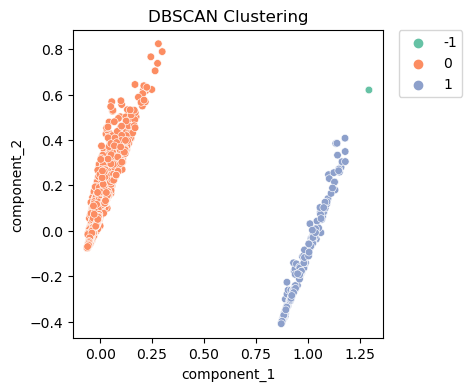

In [63]:
clusterer_name = 'dbscan'
clusterer = DBSCAN(eps=0.1, min_samples=5)

plot_clusters(clusterer_name, clusterer, X)

In [64]:
clusterer_name = 'dbscan'
clusterer = DBSCAN(eps=0.5, min_samples=5)


preprocessor = Pipeline( [("scaler", MinMaxScaler()),("pca", PCA(n_components=2, random_state=12))] ) 
clusterer = Pipeline([(clusterer_name, clusterer)])
pipe = Pipeline([("preprocessor", preprocessor), ("clusterer", clusterer)])
X_preprocessed = pipe["preprocessor"].fit_transform(X)
pipe.fit(X)

predicted_labels = pipe["clusterer"][clusterer_name].labels_
predicted_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
# Create a new dataframe to store the new feature
user_group = pd.DataFrame()
user_group['uid'] = activities.index.tolist()
user_group['group']= predicted_labels
user_group['group'].replace({0: 'general', 1: 'service'}, inplace=True)

# Save data
# user_group.to_csv('user_group.csv', index=False)

#### PCA components

In [66]:
preprocessor = Pipeline([("scaler", MinMaxScaler()), 
                          ("pca", PCA(n_components=2, random_state=42))] )
preprocessor.fit(X)

comp_df = pd.DataFrame(preprocessor["pca"].components_, 
                       columns=X.columns.to_list(), index = ['PC_1', 'PC_2']).T
pc_1 = comp_df[['PC_1']].sort_values('PC_1', ascending=False)[:5]
pc_2 = comp_df[['PC_2']].sort_values('PC_2', ascending=False)[:5]

Figure saved, pca_components.png


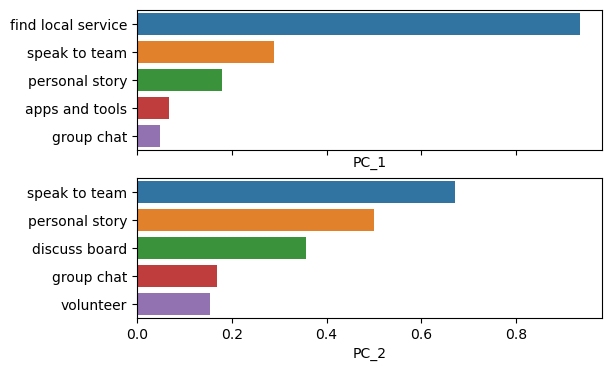

In [67]:
f, (ax1, ax2) = plt.subplots(2, 1,  sharex=True, figsize=(6,4))
sns.barplot(x='PC_1', y = pc_1.index, data=pc_1, ax=ax1)
sns.barplot(x='PC_2', y = pc_2.index, data=pc_2, ax=ax2)
save_fig('pca_components.png')
plt.show()

### TSNE

Figure saved, tsne


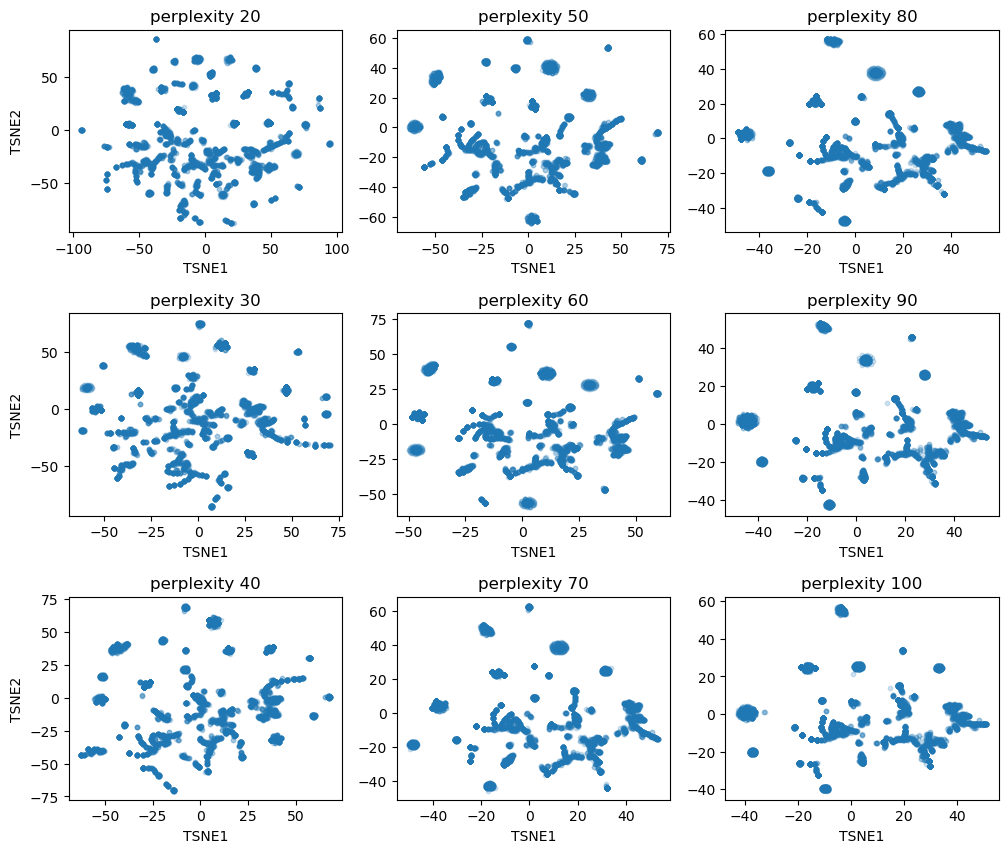

In [68]:
plot_tsne(X)
save_fig('tsne')

In [69]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
    

tsne = TSNE(n_components=2, perplexity=80, random_state=214)
X_embeded = tsne.fit_transform(X_scaled)
tsne_results = pd.DataFrame(X_embeded, index=X_scaled.index)

Figure saved, dbscan


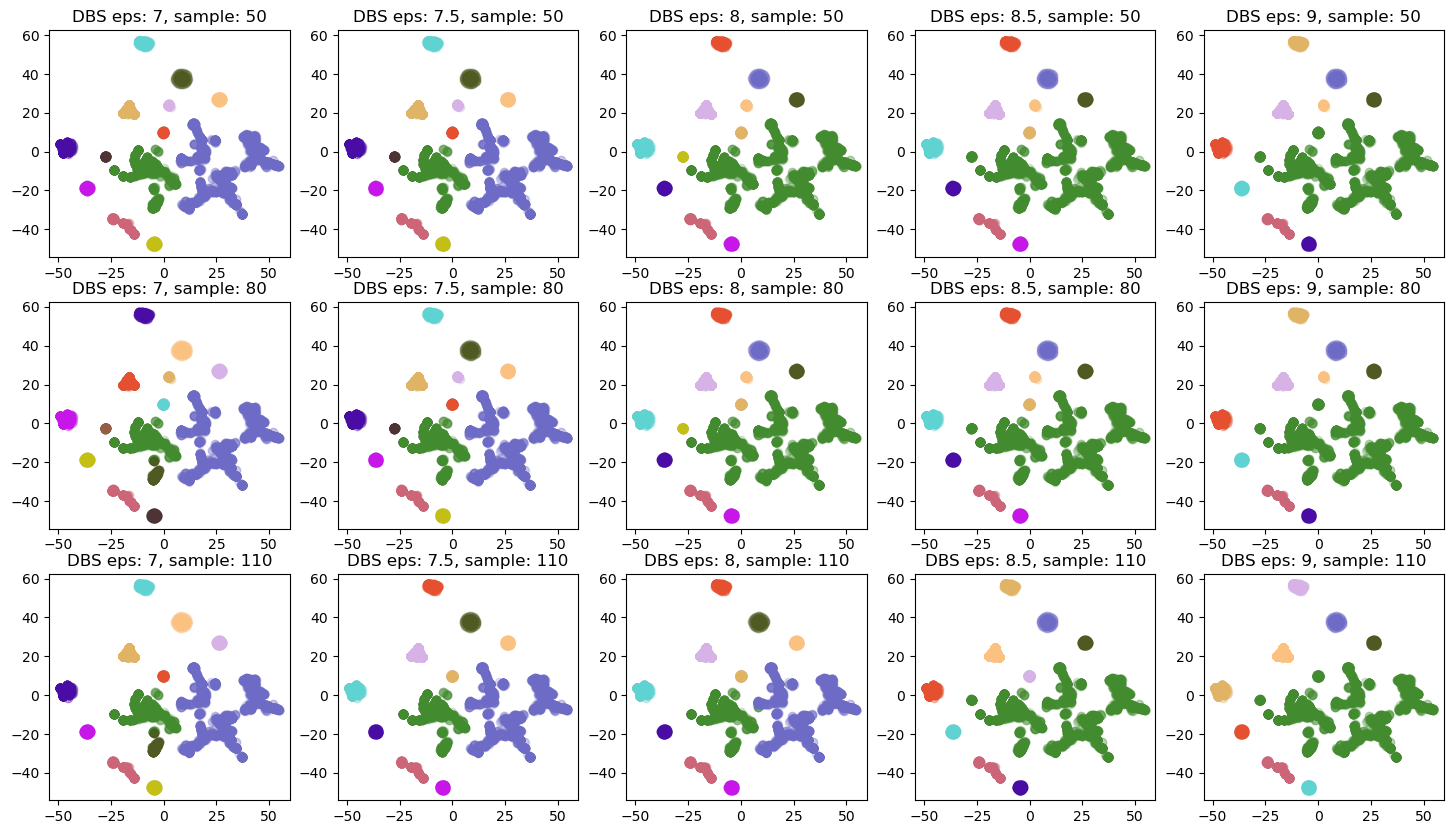

In [70]:
plot_dbscan(tsne_results)
save_fig('dbscan')

In [71]:
clusterer = DBSCAN(eps=8.5, min_samples=80).fit(tsne_results)
tsne_df = tsne_results.copy()
tsne_df.insert(0, 'cluster', clusterer.labels_)

In [72]:
test_df = pd.concat([tsne_df, activities, basic_info], axis=1)

In [73]:
test_df.groupby('cluster')[list(activities.columns)].size()

cluster
0.0      250
1.0     3451
2.0      282
3.0      213
4.0       89
5.0      629
6.0      115
7.0      209
8.0      441
9.0      213
10.0     214
dtype: int64

In [74]:
user_group = pd.DataFrame()
user_group['uid'] = activities.index.tolist()
user_group['group']= tsne_df['cluster'].values
user_group['group'].replace({0: 'dbscan_0', 1: 'dbscan_1',
                            2: 'dbscan_2', 3: 'dbscan_3',
                            4: 'dbscan_4', 5: 'dbscan_5',
                            6: 'dbscan_6', 7: 'dbscan_7',
                            8: 'dbscan_8'}, inplace=True)
# Save data
# user_group.to_csv('user_group.csv', index=False)

In [75]:
test_df.groupby('cluster')[list(activities.columns)].mean()

,expert article,discuss board,group chat,speak to team,find local service,personal story,apps and tools,skill up,volunteer,news,blog,case study,research
cluster,,,,,,,,,,,,,
0.0,3.600000,0.000000,0.000000,0.000000,0.0,1.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1.0,1.770791,0.310635,0.282817,0.636627,0.0,8.765865,0.135613,0.042596,0.491162,0.008693,0.008693,0.0,0.010142
2.0,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3.0,2.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4.0,0.022472,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6.0,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7.0,3.253589,0.148325,0.468900,1.555024,1.0,16.009569,0.722488,0.100478,0.521531,0.043062,0.019139,0.0,0.009569
8.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
